<a href="https://colab.research.google.com/github/KanwardeepChopra/Promotional-Sales-volume-forecasting-model/blob/main/Sales_Volume_forecasting_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [ ]:
df= pd.read_excel('/content/Digi Challenge - UK Data.xlsx')
df.head()

,Level8Code,Customer,PromoIDText,PromoFlag,TUEAN,WeekSkID,InStoreStartWeek,InStoreEndWeek,PromotionStatus,InstoreStartDate,...,ActualBaselineVolume,ActualBaselineValue,ActualBaseGSVSellOut,ActualBaseTTSOnSpend,ActualBaseNIVSellOut,ActualBaseTTSOffSpend,ActualBaseTOSellOut,ActualBaseGrossProfitsSellOut,ActualBaseCOGSSellOut,ActualEventSpend
0,335871,ASDA STORES LTD.,P-00085030,ASDA STORES LTD-Twister IH 70ml 7mpk x 6-Other...,8711327394452,2021-38,2021.36,2021.39,Executed,2021-09-09,...,71.00000,116.44000,109.3400,17.68028,91.65972,0.07664,91.58308,48.90108,42.68201,11.58667
1,335871,ASDA STORES LTD.,P-00085030,ASDA STORES LTD-Twister IH 70ml 7mpk x 6-Other...,8711327394452,2021-37,2021.36,2021.39,Executed,2021-09-09,...,186.00000,331.08000,286.4400,46.31735,240.12265,0.20077,239.92188,128.10705,111.81483,25.80667
2,335871,ASDA STORES LTD.,P-00085030,ASDA STORES LTD-Twister IH 70ml 7mpk x 6-Other...,8711327394452,2021-39,2021.36,2021.39,Executed,2021-09-09,...,7.19571,11.80097,11.0814,1.79186,9.28954,0.00167,9.28787,4.96213,4.32574,1.63722
3,335871,ASDA STORES LTD.,P-00085030,ASDA STORES LTD-Twister IH 70ml 7mpk x 6-Other...,8711327394452,2021-36,2021.36,2021.39,Executed,2021-09-09,...,77.59429,146.65320,119.4952,19.32237,100.17283,0.04786,100.12497,53.47877,46.64619,39.34895
4,335871,ASDA STORES LTD.,P-00083952,ASDA STORES LTD-Twister IH 70ml 7mpk x 6-Other...,8711327394452,2021-36,2021.33,2021.36,Executed,2021-08-19,...,43.64571,82.49040,67.2144,10.86857,56.34583,0.02019,56.32564,30.08780,26.23784,5.22992


In [ ]:
# Check for null values and determine the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088 entries, 0 to 1087
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Level8Code                         1088 non-null   int64         
 1   Customer                           1088 non-null   object        
 2   PromoIDText                        1088 non-null   object        
 3   PromoFlag                          1088 non-null   object        
 4   TUEAN                              1088 non-null   int64         
 5   WeekSkID                           1088 non-null   object        
 6   InStoreStartWeek                   1088 non-null   float64       
 7   InStoreEndWeek                     1088 non-null   float64       
 8   PromotionStatus                    1088 non-null   object        
 9   InstoreStartDate                   1088 non-null   datetime64[ns]
 10  InstoreEndDate                     1

In [ ]:
# Fill in null values with zeroes (both 'null' strings and NaNs) and cast columns into floats
object_to_float_columns = []
df[object_to_float_columns] = df[object_to_float_columns].replace('null', 0).fillna(0).astype(float)

# Fill in null values and cast columns into strings/objects
int_to_object_columns = ['InStoreStartWeek','InStoreEndWeek']
df[int_to_object_columns] = df[int_to_object_columns].fillna('null').astype(str)

# Create a new column with the calculated Actual Incremental Gross Profit (ActualIGP)
df['ActualIGP'] = (df['ActualNetPromoGrossProfitsSellOut'] - df['ActualBaseGrossProfitsSellOut']).astype(float)
# Extract the year and week from the 'WeekSKID' column
df.loc[:, 'Year'] = df['WeekSkID'].str[:4].astype(int)
df.loc[:, 'Week'] = df['WeekSkID'].str[-2:].astype(int)

# Identify the categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_df = df[categorical_columns]
numerical_df = df[numerical_columns]
print(f"Categorical Columns:\n{categorical_columns}")
print(f"Numerical Columns:\n{numerical_columns}")

Categorical Columns:
['Customer', 'PromoIDText', 'PromoFlag', 'WeekSkID', 'InStoreStartWeek', 'InStoreEndWeek', 'PromotionStatus', 'PromoFeature', 'PromoMechanic', 'PromoShopperMechanic', 'DivisionName_VG', 'CategoryName_VG', 'SegmentName_VG', 'FormName_VG', 'EBFName_VG', 'Brand_VG', 'SPF', 'SPFVName_VG']
Numerical Columns:
['Level8Code', 'TUEAN', 'ListPrice', 'PlannedPromoSalesVolumeSellIn', 'PlannedNetPromoGSVSellIn', 'PlannedTTSOnSpend', 'PlannedNetPromoNIVSellIn', 'PlannedTTSOffSpend', 'PlannedNetPromoTOSellIn', 'PlannedNetPromoGrossProfitsSellIn', 'PlannedNetPromoCOGSSellIn', 'PlannedBaselineVolume', 'PlannedBaseGSVSellIn', 'PlannedBaseTTSOnSpend', 'PlannedBaseNIVSellIn', 'PlannedBaseTTSOffSpend', 'PlannedBaseTOSellIn', 'PlannedBaseGrossProfitsSellIn', 'PlannedBaseCOGSSellIn', 'PlannedEventSpend', 'ActualPromoSalesValueSellOut', 'ActualPromoSalesVolumeSellOut', 'ActualNetPromoGSVSellOut', 'ActualTTSOnSpend', 'ActualNetPromoNIVSellOut', 'ActualTTSOffSpend', 'ActualNetPromoTOSellOut

In [ ]:
# Calculate correlations of the numerical data with the target column
correlations = df[numerical_columns].corrwith(df['ActualPromoSalesVolumeSellOut'])
# Rank the correlations by their absolute values
ranked_correlations = correlations.abs().sort_values(ascending=False)
# Display the ranked correlations
ranked_correlations

,0
ActualPromoSalesVolumeSellOut,1.000000
ActualNetPromoGSVSellOut,0.997774
ActualPromoSalesValueSellOut,0.993709
ActualNetPromoNIVSellOut,0.992307
ActualNetPromoTOSellOut,0.984135
ActualNetPromoCOGSSellOut,0.983769
ActualTTSOnSpend,0.970365
ActualTTSOffSpend,0.889550
ActualEventSpend,0.877207
ActualNetPromoGrossProfitsSellOut,0.865969


In [ ]:
columns_to_drop=['PromoFlag', 'PromotionStatus', 'InstoreStartDate', 'InstoreEndDate', 'ShipmentStartDate', 'ShipmentEndDate', 'WeekSkID']
one_hot_encoder_values = ['Customer', 'DivisionName_VG', 'CategoryName_VG', 'SegmentName_VG', 'FormName_VG', 'EBFName_VG', 'Brand_VG', 'SPF', 'PromoFeature', 'PromoMechanic', 'PromoShopperMechanic', 'SPFVName_VG', 'Level8Code', 'PromoIDText', 'TUEAN']
ordinal_encoder_values = [ 'InStoreStartWeek', 'InStoreEndWeek']
numerical_values = ['ListPrice',  'PlannedNetPromoGSVSellIn', 'PlannedTTSOnSpend', 'PlannedNetPromoNIVSellIn', 'PlannedTTSOffSpend', 'PlannedNetPromoTOSellIn', 'PlannedNetPromoGrossProfitsSellIn', 'PlannedNetPromoCOGSSellIn', 'PlannedBaselineVolume', 'PlannedBaseGSVSellIn', 'PlannedBaseTTSOnSpend', 'PlannedBaseNIVSellIn', 'PlannedBaseTTSOffSpend', 'PlannedBaseTOSellIn', 'PlannedBaseGrossProfitsSellIn', 'PlannedBaseCOGSSellIn', 'PlannedEventSpend', 'ActualPromoSalesValueSellOut', 'ActualNetPromoGSVSellOut', 'ActualNetPromoNIVSellOut', 'ActualTTSOffSpend', 'ActualNetPromoTOSellOut', 'ActualNetPromoGrossProfitsSellOut', 'ActualNetPromoCOGSSellOut', 'ActualBaselineVolume', 'ActualBaselineValue', 'ActualBaseGSVSellOut', 'ActualBaseTTSOnSpend', 'ActualBaseNIVSellOut', 'ActualBaseTTSOffSpend', 'ActualBaseTOSellOut', 'ActualBaseGrossProfitsSellOut', 'ActualBaseCOGSSellOut', 'ActualEventSpend', 'ActualTTSOnSpend', 'PlannedPromoSalesVolumeSellIn', 'ActualIGP',  'Week', 'Year']
target_variable = ['ActualPromoSalesVolumeSellOut']

In [ ]:
# Preprocess the DataFrame and split it into the testing and training sets
def preprocess(df: pd.DataFrame, columns_to_drop: np.ndarray, one_hot_encoder_values: np.ndarray, ordinal_encoder_values: np.ndarray, numerical_values: np.ndarray, target_variable: np.ndarray):

    # Drop columns that are not needed
    df_model = df.drop(columns=columns_to_drop)

    # Replace 'null' strings with NaN values
    df_model.replace('null', np.nan, inplace=True)

    # Convert numerical columns to floats and ordinal columns to strings
    for column in numerical_values:
        df_model[column] = pd.to_numeric(df_model[column], errors='coerce')
    for column in ordinal_encoder_values:
        df_model[column] = df_model[column].astype(str)

    # Drop rows with missing values
    df_model = df_model.dropna(subset=one_hot_encoder_values + ordinal_encoder_values + numerical_values + target_variable)

    # Ensure there are no infinite or excessively large values in numerical features and target
    df_model = df_model[np.isfinite(df_model[numerical_values + target_variable]).all(axis=1)]

    # Standardize the target variable helps to ensure that the target values have a mean of 0 and a standard deviation of 1
    target_scaler = StandardScaler()
    df_model[target_variable] = target_scaler.fit_transform(df_model[target_variable].values.reshape(-1, 1))

    # Define the preprocessor pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_values),
            ('cat', OneHotEncoder(handle_unknown='ignore'), one_hot_encoder_values),
            ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_encoder_values)
    ])

    # Split data into features (X) and target (y) and covert the latter to the correct shape
    X = df_model[one_hot_encoder_values + ordinal_encoder_values + numerical_values]
    y = df_model[target_variable].values.ravel()

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the preprocessor and transform the training data and testing data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test, y_train, y_test, preprocessor, target_scaler

X_train, X_test, y_train, y_test, preprocessor, target_scaler = preprocess(df, columns_to_drop, one_hot_encoder_values, ordinal_encoder_values, numerical_values, target_variable)

In [ ]:
# Inverse transform the predictions and the target values to convert them back to their original scale
def postprocess(predictions, y_test, target_scaler):
    # Use the fitted scaler to inverse transform the predictions
    inverse_predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()
    # Use the fitted scaler to inverse transform the test target values (y_test)
    inverse_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
    # Return the inverse transformed predictions and test target values
    return inverse_predictions, inverse_y_test

In [ ]:
# Calculate simple error
def _error(actual: np.ndarray, predicted: np.ndarray):
    return actual - predicted

# Calculate mean absolute error
def mae(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.abs(_error(actual, predicted)), axis=0)

# Calculate mean squared error
def mse(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.square(_error(actual, predicted)), axis=0)

# Calculate root mean squared error
def rmse(actual: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mse(actual, predicted))

# Calculate forecast bias (mean forecast error)
def bias(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(actual - predicted)

METRICS = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "bias": bias
}

# Create a function to evaluate the model based on each metric
def evaluate(actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "mse", "rmse", "bias")):
    results = {}
    for metric in metrics:
        try:
            results[metric] = METRICS[metric](actual, predicted)
        except Exception as err:
            results[metric] = np.nan
            print("ERROR Unable to compute {0}: {1}".format(metric, err))
    return results

# Initialize the dictionaries to store the results and predictions
results = {}
predictions = {}

In [ ]:
def random_forest(X_train, X_test, y_train, y_test):
  # Initialize the RandomForestRegressor model with 100 trees, a maximum depth of 10, and a random state of 0
  rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=0
  )
  # Fit the RandomForestRegressor model to the training data
  rf_model.fit(X_train, y_train)
  # Predict the target values for the test data
  rf_predictions = rf_model.predict(X_test)
  # Inverse transform the predictions and the test target values using the postprocess function
  inverse_predictions, inverse_y_test = postprocess(rf_predictions, y_test, target_scaler)
  # Evaluate the model's performance and store the results
  results['RandomForest'] = evaluate(inverse_y_test, inverse_predictions)
  predictions['RandomForest'] = inverse_predictions
  return rf_model, inverse_y_test
rf_model, inverse_y_test = random_forest(X_train, X_test, y_train, y_test)

Text(0.5, 1.0, 'Original Versus Predicted Sales Volume')

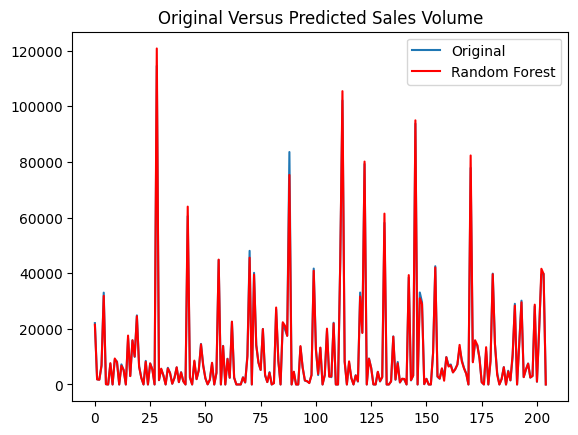

In [ ]:
# Plot the original test target values
plt.plot(inverse_y_test, label='Original')
# Plot the predictions from the Random Forest model
plt.plot(predictions['RandomForest'], color='red', label='Random Forest')
# Add a legend to the plot to differentiate between the original and predicted values
plt.legend()
plt.title('Original Versus Predicted Sales Volume')

In [ ]:
def xgboost(X_train, X_test, y_train, y_test):
    # Initialize the XGBoost model with 100 trees, a maximum depth of 10, and the squared error objective
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        objective='reg:squarederror',
    )
    # Fit the XGBoost model to the training data
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    # Predict the target values for the test data
    xgb_predictions = xgb_model.predict(X_test)
    # Inverse transform the predictions and the test target values using the postprocess function
    inverse_predictions, inverse_y_test = postprocess(xgb_predictions, y_test, target_scaler)
    # Evaluate the model's performance and store the results
    results['XGBoost'] = evaluate(inverse_y_test, inverse_predictions)
    predictions['XGBoost'] = inverse_predictions
    return xgb_model, inverse_y_test

xgb_model, inverse_y_test = xgboost(X_train, X_test, y_train, y_test)

Text(0.5, 1.0, 'Original Versus Predicted Sales Volume')

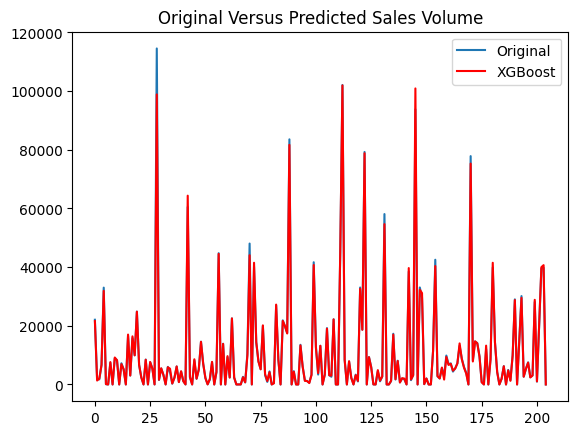

In [ ]:
# Plot the original test target values
plt.plot(inverse_y_test, label='Original')
# Plot the predictions from the XGBoost model
plt.plot(predictions['XGBoost'], color='red', label='XGBoost')
# Add a legend to the plot to differentiate between the original and predicted values
plt.legend()
plt.title('Original Versus Predicted Sales Volume')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def dnn(X_train, X_test, y_train, y_test):
    # Build the neural network model
    dnn_model = Sequential()
    dnn_model.add(Input(shape=(X_train.shape[1],)))  # Explicit Input layer
    dnn_model.add(Dense(16, activation='relu'))
    dnn_model.add(Dense(8, activation='relu'))
    dnn_model.add(Dense(4, activation='relu'))
    dnn_model.add(Dense(1, activation='linear'))
    # Compile the model
    dnn_model.compile(optimizer='adam', loss='mean_absolute_error')
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    # Fit the DNN model to the training data
    history = dnn_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2, callbacks=[early_stopping])
    # Evaluate the model
    loss = dnn_model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')
    # Predict the target values for the test data
    dnn_predictions = dnn_model.predict(X_test)
    # Inverse transform the predictions and the test target values using the postprocess function
    inverse_predictions, inverse_y_test = postprocess(dnn_predictions, y_test, target_scaler)
    # Evaluate the model's performance and store the results
    results['DNN'] = evaluate(inverse_y_test, inverse_predictions)
    predictions['DNN'] = inverse_predictions
    return dnn_model, inverse_y_test, history

dnn_model, inverse_y_test, history = dnn(X_train, X_test, y_train, y_test)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.7821 - val_loss: 0.2362
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2603 - val_loss: 0.1935
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2161 - val_loss: 0.1462
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2050 - val_loss: 0.1082
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1105 - val_loss: 0.1074
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1035 - val_loss: 0.0730
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1012 - val_loss: 0.0761
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0812 - val_loss: 0.0559
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0630 - val_loss: 0.1032
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1056 - val_loss: 0.0550
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0600 - val_loss: 0.0659
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0592 - val_l

In [ ]:
dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │           4,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,069 (54.96 KB)

 Trainable params: 4,689 (18.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,380 (36.64 KB)

Text(0.5, 1.0, 'Original Versus Predicted Sales Volume')

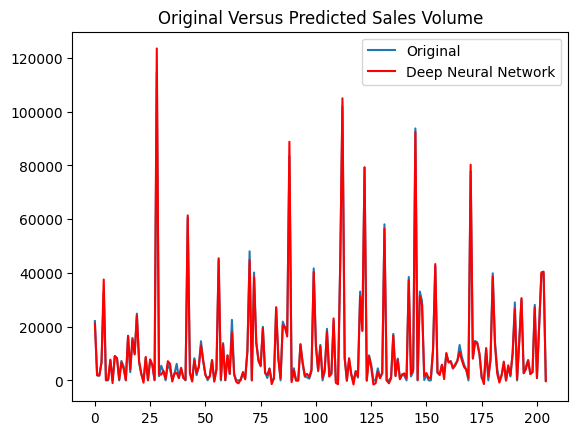

In [ ]:
# Plot the original test target values
plt.plot(inverse_y_test, label='Original')
# Plot the predictions from the DNN model
plt.plot(predictions['DNN'], color='red', label='Deep Neural Network')
# Add a legend to the plot to differentiate between the original and predicted values
plt.legend()
plt.title('Original Versus Predicted Sales Volume')

In [ ]:
# Loop over each model and print its corresponding metrics
for model, metrics in results.items():
    print(model)
    for metric in metrics:
        print(f'{metric}:{metrics[metric]}')
    print("\n")

RandomForest
mae:372.93329966082564
mse:989334.0869025885
rmse:994.6527468934013
bias:-39.83703383838112


XGBoost
mae:385.47156086300816
mse:1846919.3866647275
rmse:1359.0141230556537
bias:69.53438050331097


DNN
mae:768.2252094623525
mse:1578575.829725735
rmse:1256.4138767642353
bias:100.1061936607299




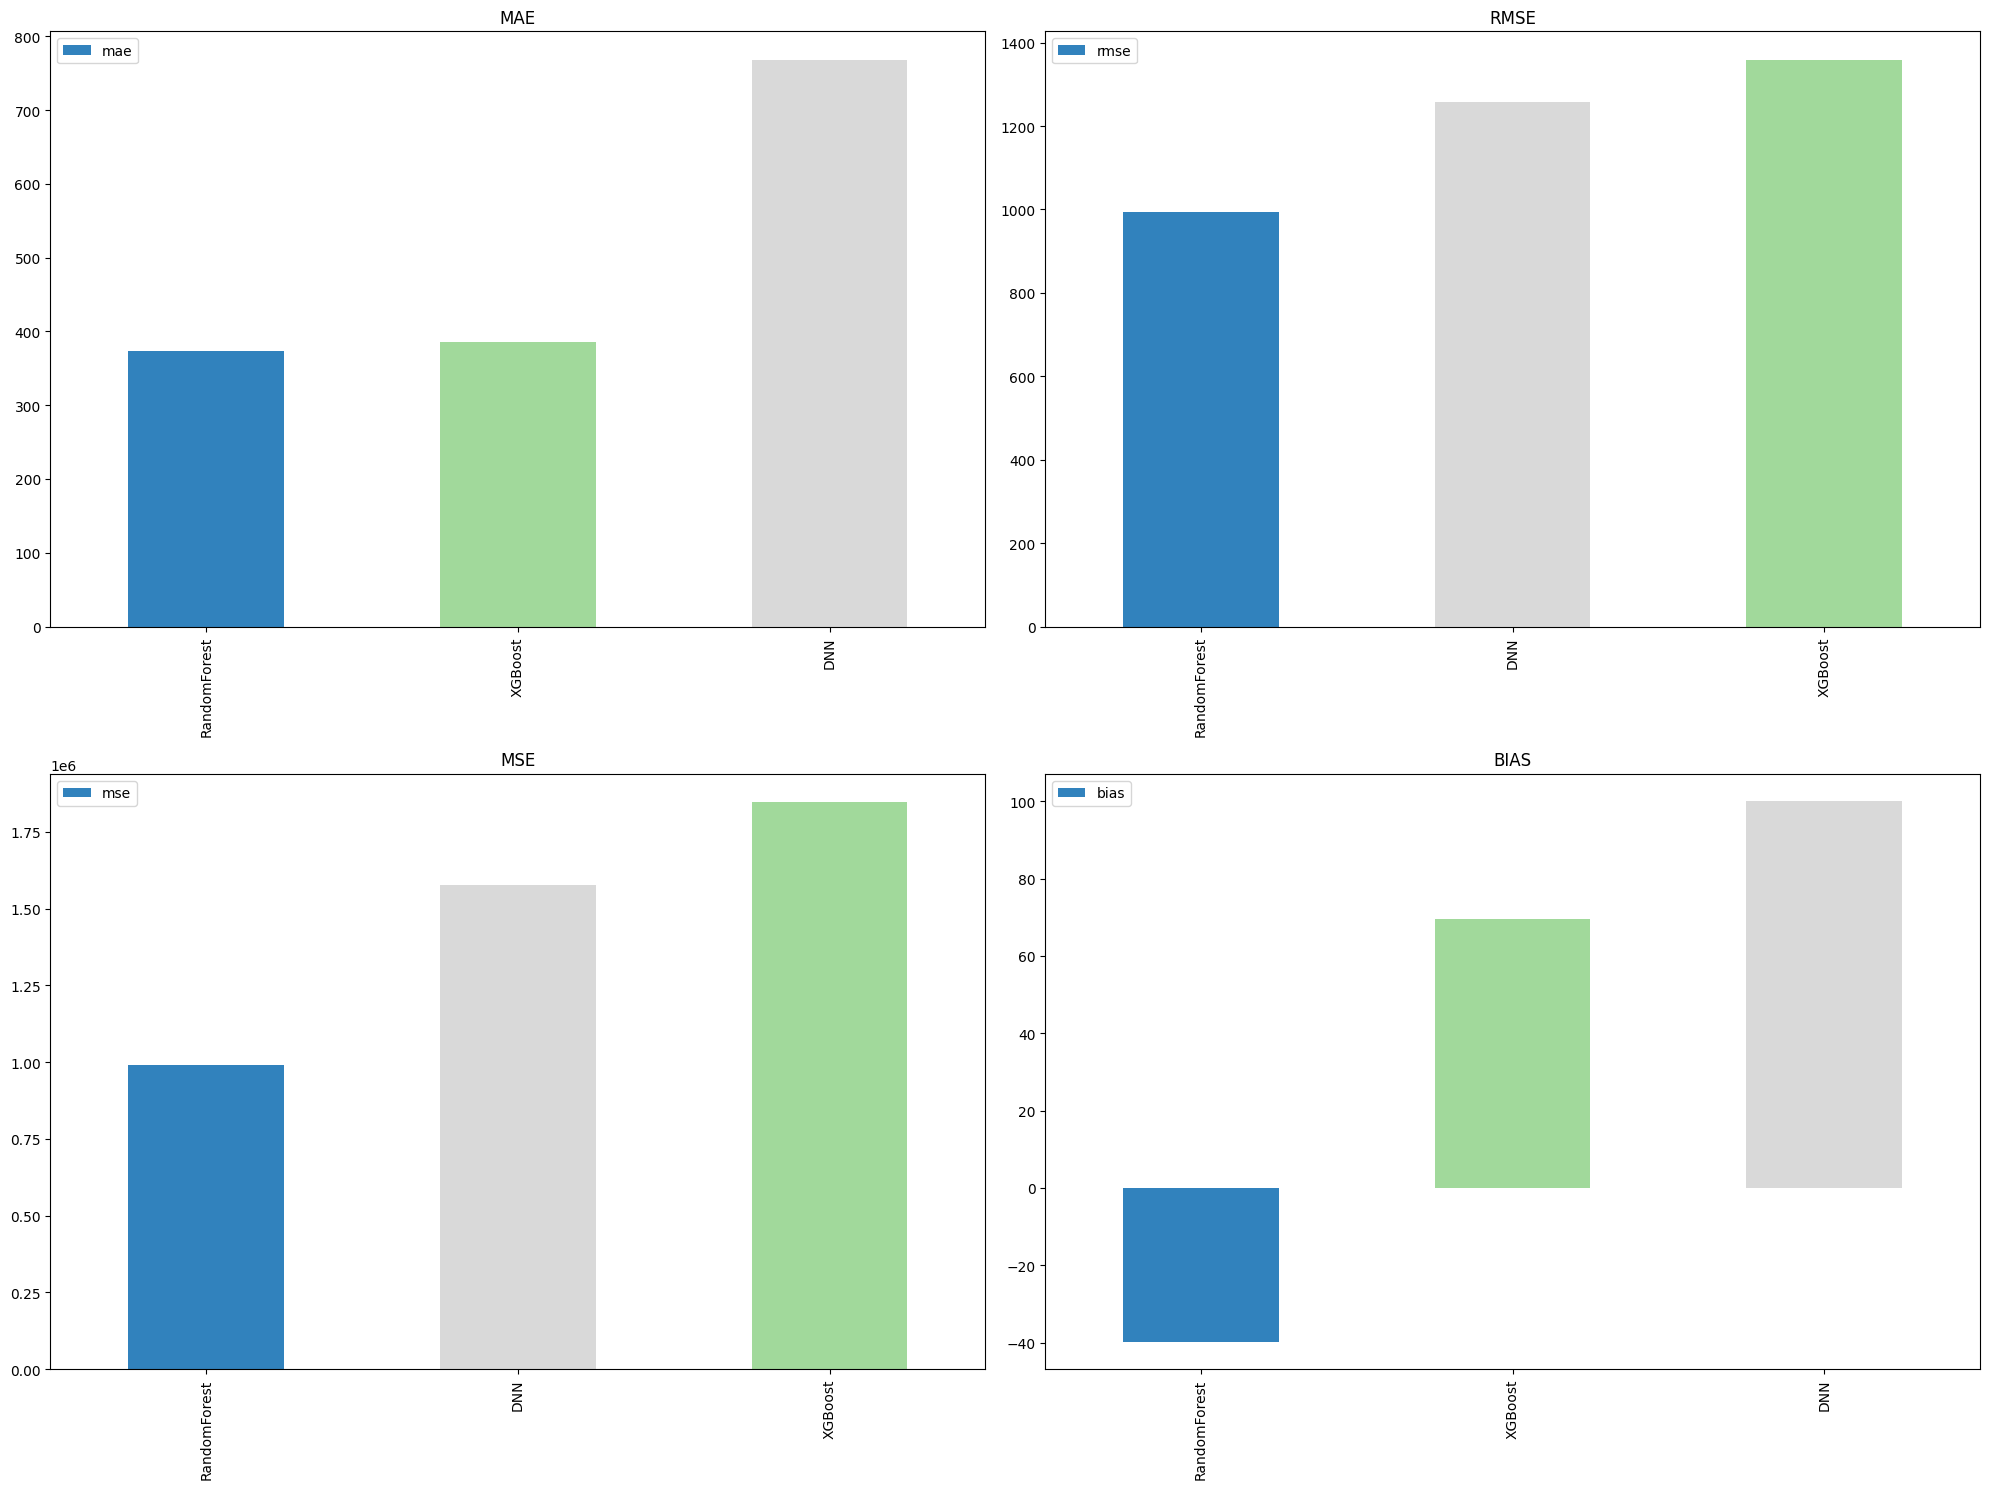

In [ ]:
# Flatten the nested arrays in the results dictionary
def flatten_results(results):
    flattened = {}
    for model, metrics in results.items():
        flattened[model] = {metric: value[0] if isinstance(value, np.ndarray) else value for metric, value in metrics.items()}
    return flattened

def plot_bar_metrics(results, metrics=["mae", "rmse", "mse", "bias"]):
    # Flatten the results dictionary
    flattened_results = flatten_results(results)
    # Convert the flattened results dictionary to a DataFrame
    df = pd.DataFrame.from_dict(flattened_results)
    # Get the default color cycle from Matplotlib
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Create a color palette with a specified number of colors
    pallette = plt.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    # Create a dictionary mapping each column to a color
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))
    # Initialize the subplot index
    idx = 1
    # Loop through each metric in the metrics list
    for metric in metrics:
        # Add a subplot to the figure
        fig.add_subplot(2, 2, idx)
        # Plot the sorted values of the metric as a bar chart
        df.loc[metric].sort_values().plot(
            kind="bar",
            color=[color_dict.get(x, "#333333") for x in df.loc[metric].sort_values().index],
        )
        plt.legend()
        # Set the title of the plot to the uppercase metric name
        plt.title(metric.upper())
        # Increment the subplot index
        idx += 1
    plt.tight_layout()
    plt.show()
plot_bar_metrics(results)

In [ ]:
def preprocess_validation(df: pd.DataFrame, columns_to_drop: np.ndarray, preprocessor: ColumnTransformer):
    # Add new features - Actual Incremental Gross Profit (ActualIGP), Year, and Week
    df['ActualIGP'] = (df['ActualNetPromoGrossProfitsSellOut'] - df['ActualBaseGrossProfitsSellOut']).astype(float)
    df.loc[:, 'Year'] = df['WeekSkID'].str[:4].astype(int)
    df.loc[:, 'Week'] = df['WeekSkID'].str[-2:].astype(int)

    # Drop columns that are not needed
    df_model = df.drop(columns=columns_to_drop)

    # Replace 'null' strings with NaN values
    df_model.replace('null', np.nan, inplace=True)

    # Convert numerical columns to floats and ordinal columns to strings
    for column in numerical_values:
        df_model[column] = pd.to_numeric(df_model[column], errors='coerce')
    for column in ordinal_encoder_values:
        df_model[column] = df_model[column].astype(str)

    # Drop rows with missing values
    df_model = df_model.dropna(subset=one_hot_encoder_values + ordinal_encoder_values + numerical_values)

    # Ensure there are no infinite or excessively large values in numerical features and target
    df_model = df_model[np.isfinite(df_model[numerical_values]).all(axis=1)]

    # Transform the validation data using the preprocessor fitted on the training set
    X_validation = preprocessor.transform(df_model)

    return X_validation

In [ ]:
# Read the table from the CSV (comma-separated values) file in Unity Catalog
validation_df = pd.read_excel('/content/Digi Challenge - UK Data.xlsx')
# Preprocess the validation set
X_validation = preprocess_validation(validation_df, columns_to_drop, preprocessor)
# Predict the target values for the validation set
y_pred = dnn_model.predict(X_validation)
# Inverse transform the predictions to convert them back to their original scale
inverse_validation_predictions =  target_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
primary_key_columns = validation_df[['PromoIDText', 'WeekSkID', 'TUEAN']]
submission_df = pd.DataFrame(y_pred, columns=['ActualPromoSalesVolumeSellOut'])
submission_df = pd.concat([submission_df, primary_key_columns.reset_index(drop=True)], axis=1)
submission_df['ActualPromoSalesVolumeSellOut'] = submission_df['ActualPromoSalesVolumeSellOut'].apply(lambda x: f'{x:.0f}')
# Save the DataFrame to a CSV file
submission_df.to_csv('submission_0_uk.csv', index=False)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
